## Example 4.2: Jack’s Car Rental

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. **If Jack has a car available, he rents it out and is credited $10 by the national company**. If he is out of cars at that location, then the business is lost. **Cars become available for renting the day after they are returned**. To help ensure that cars are available where they are needed, **Jack can move them between the two locations overnight, at a cost of $2 per car moved**. We assume that **the number of cars requested and returned at each location are Poisson random variables**, meaning that the probability that the number is n is\
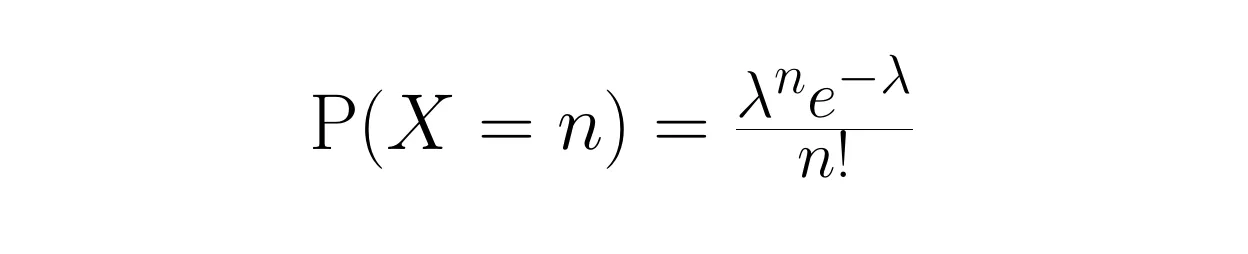
where lambda is the expected number. To simplify the problem slightly,
we assume that
- there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem)
- a maximum of five cars can be moved from one location to the other in one night.
- We take the discount rate to be gamma = 0.9


To formulate this as a continuing finite MDP:
- the `time steps` are days
- the `state` is the number of cars at each location at the end of
the day
- `actions` are the net numbers of cars moved between the two locations
overnight.

- import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np


### Define an States, Actions

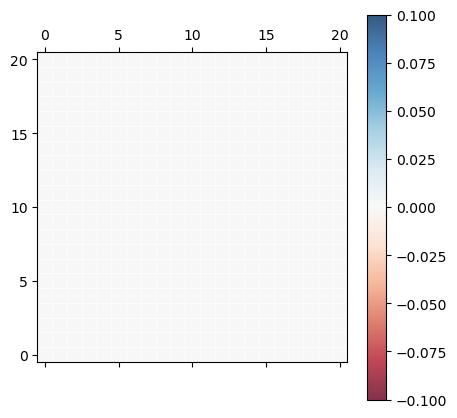

In [2]:
N_ROW = 20
N_COL = 20
STATES = {(i, j) for i in range(N_ROW+1) for j in range(N_COL+1)}
ACTIONS = {i for i in range(-5, 6)}

def plot_values(values):
    """
    Plot the values of the states in a grid.

    Parameters
    ----------
    values : dict
        A dictionary containing the values of the states. The keys are the states
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    vals = []
    for i in range(N_ROW+1):
        row = []
        for j in range(N_COL+1):
            row.append(values[(i, j)])
        vals.append(row)
    im = ax.matshow(vals, cmap="RdBu", alpha=0.8)
    for i in range(N_ROW+1):
        for j in range(N_COL+1):
            ax.plot([j-0.5, j-0.5], [i-0.5, i+0.5], c="white", linewidth=0.5)
            ax.plot([j-0.5, j+0.5], [i-0.5, i-0.5], c="white", linewidth=0.5)
    ax.invert_yaxis()
    cbar = fig.colorbar(im)
    plt.show()

values = {state:0 for state in STATES}
plot_values(values)

### Define transition

In [3]:
def transition(state, action):
    """
    Transition function for the Jack's Car Rental problem.

    Parameters
    ----------
    state : tuple
        A tuple containing the number of cars at location A and location B
    action : int
        The number of cars to move from location A to location B. If positive, the cars are moved from B to A
    
    Returns
    -------
    tuple
        A tuple containing the number of cars at location A and location B after the transition
    """

    cars_at_a = state[0] + action
    cars_at_b = state[1] - action

    if cars_at_a < 0 or cars_at_b < 0:
        return state
    
    if cars_at_a >= N_ROW:
        cars_at_a = N_ROW
    if cars_at_b >= N_COL:
        cars_at_b = N_COL
    
    return (cars_at_a, cars_at_b)
    
# Test the transition function
start_point = (3, 18)
for action in ACTIONS:
    print(start_point, action, transition(start_point, action))

(3, 18) 0 (3, 18)
(3, 18) 1 (4, 17)
(3, 18) 2 (5, 16)
(3, 18) 3 (6, 15)
(3, 18) 4 (7, 14)
(3, 18) 5 (8, 13)
(3, 18) -1 (2, 19)
(3, 18) -5 (3, 18)
(3, 18) -4 (3, 18)
(3, 18) -3 (0, 20)
(3, 18) -2 (1, 20)


### Define Reward (demand and return)

In [4]:
def poisson(n, lam):
    """
    Poisson distribution.

    Parameters
    ----------
    n : int
        number of occurrences
    lam : int
        lambda parameter

    Returns
    -------
    probability : float
        The probability of n occurrences given lambda
    """
    return np.exp(-lam) * lam**n / np.math.factorial(n)

def get_reward(state, action, values, gamma = 0.9):
    """
    Get the reward for a state-action pair.

    Parameters
    ----------
    state : set
        set of states
    action : set
        set of actions
    values : dict
        dictionary containing the values of the states
    gamma : float, optional
        discount factor, by default 0.9

    Returns
    -------
    value : float
        value of the state-action pair
    """
    epsilon = 0.01 # threshold for a small number to speed up the computation
    next_state = transition(state, action)

    value = -2 * abs(action)
    cars_at_a = next_state[0]
    cars_at_b = next_state[1]
    for demand_a in range(N_ROW+1):
        p_demand_a = poisson(demand_a, 3)
        if p_demand_a < epsilon:
            continue
        if demand_a > cars_at_a:
            demand_a = cars_at_a
        for demand_b in range(N_COL+1):
            p_demand_b = poisson(demand_b, 2)
            if p_demand_b < epsilon:
                continue
            if demand_b > cars_at_b:
                demand_b = cars_at_b
            for return_a in range(N_ROW+1+5):
                p_return_a = poisson(return_a, 3)
                if p_return_a < epsilon:
                    continue
                for return_b in range(N_COL+1+5):
                    p_return_b = poisson(return_b, 2)
                    if p_return_b < epsilon:
                        continue
                    new_cars_at_a = cars_at_a - demand_a + return_a
                    new_cars_at_b = cars_at_b - demand_b + return_b
                    if new_cars_at_a < 0 or new_cars_at_b < 0:
                        continue
                    if new_cars_at_a >= N_ROW:
                        new_cars_at_a = N_ROW
                    if new_cars_at_b >= N_COL: 
                        new_cars_at_b = N_COL
                    
                    p = p_demand_a * p_demand_b * p_return_a * p_return_b
                    reward = 10 * (demand_a + demand_b)
                    value +=  p*(reward + gamma*values[(new_cars_at_a, new_cars_at_b)])           
    return value

### Define Policy and Evaluate Policy

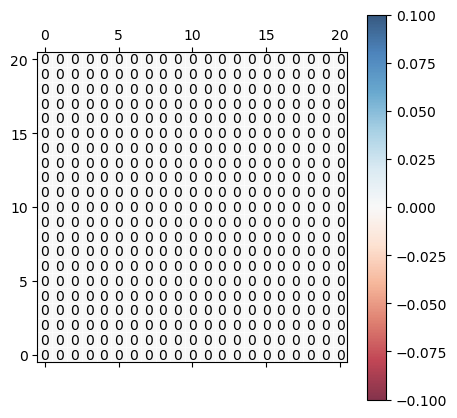

total reward:29429.131792617405	delta:108.67312877606153
total reward:56335.72856790564	delta:68.4220322543401
total reward:77853.4861285267	delta:56.663088009964
total reward:94588.5693750029	delta:44.724583452222845
total reward:107543.31622566843	delta:34.91972851896861
total reward:117564.49522515814	delta:27.578116954173936
total reward:125314.82420021127	delta:21.622284003439972
total reward:131308.21536473793	delta:16.880030717039574
total reward:135942.63219059972	delta:13.141622368726019
total reward:139526.06226033805	delta:10.212253552917446


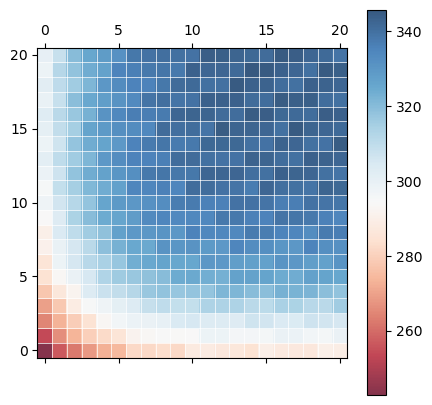

142296.7717457692


In [5]:
def policy_evaluation(values, policy, gamma = 0.9, theta = 0.1):
    """
    Evaluate a policy given the values of the states.

    Parameters
    ----------
    values : dict
        dictionary containing the values of the states
    policy : dict
        dictionary containing the policy
    gamma : float, optional
        discount factor, by default 0.9
    theta : float, optional
        theta, by default 0.1

    Returns
    -------
    values : dict
        updated dictionary containing the values of the states
    """
    while True:
        delta = 0
        i  = 0 
        n = len(STATES)
        for state in STATES:
            v = values[state]
            action = policy[state]
            values[state] =  get_reward(state, action, values, gamma)
            i+=1
            print('{:.2f}: val {:.2f}'.format(i/n, values[state]), end='\r')
            delta = max(delta, abs(v - values[state]))
        if delta < theta:
            break
        print(f'total reward:{sum(values.values())}\tdelta:{delta}')
    return values

def plot_policy(policy):
    """
    Plot the policy in a grid.

    Parameters
    ----------
    policy : dict
        dictionary containing the policy. The keys are the states

    """
    
    fig, ax = plt.subplots(figsize=(5, 5))
    vals = []
    for i in range(N_ROW+1):
        row = []
        for j in range(N_COL+1):
            key = policy[(i, j)]
            row.append(key)
        vals.append(row)
    im = ax.matshow(vals, cmap="RdBu", alpha=0.8)
    for i in range(N_ROW+1):
        for j in range(N_COL+1):
            ax.plot([j-0.5, j-0.5], [i-0.5, i+0.5], c="white", linewidth=0.5)
            ax.plot([j-0.5, j+0.5], [i-0.5, i-0.5], c="white", linewidth=0.5)
            ax.text(j, i, vals[i][j], va='center', ha='center')
    ax.invert_yaxis()
    cbar = fig.colorbar(im)
    plt.show()
values = {state:0 for state in STATES}
policy = {state:0 for state in STATES}
plot_policy(policy)

values = policy_evaluation(values, policy, theta=10)
plot_values(values) 
R = sum(values.values())
print(R)


### Policy Improvements

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!8         


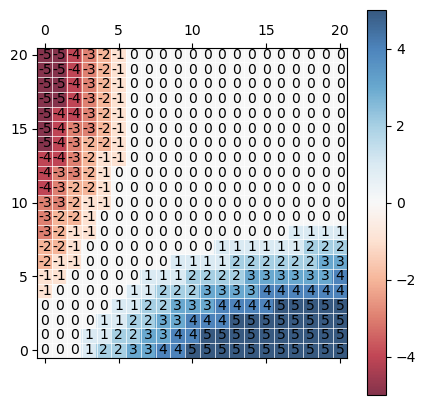

total reward:146119.86222862292	delta:36.87962719898843
total reward:148053.72792883308	delta:6.8032775131653125
total reward:149515.65833175243	delta:3.9600719274475296
total reward:150638.78890647346	delta:3.0472336122236356
total reward:151503.73404052784	delta:2.3419107699807
total reward:152170.39897975262	delta:1.7960711258123183
total reward:152684.4112854015	delta:1.3770252348553527
total reward:153080.79014601768	delta:1.0563136558412225


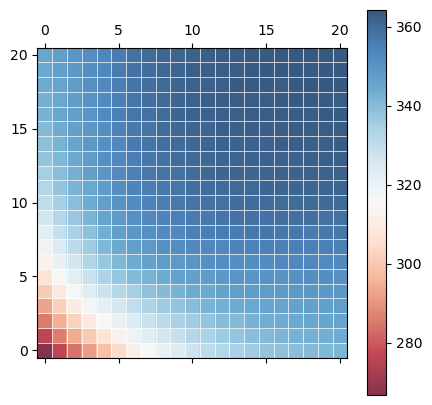

In [6]:
def policy_improvement(values, policy, gamma = 0.9):
    """
    Improve the policy given the values of the states.

    Parameters
    ----------
    values : dict
        dictionary containing the values of the states
    policy : dict
        dictionary containing the policy
    gamma : float, optional
        discount factor, by default 0.9

    Returns
    -------
    policy : dict
        updated dictionary containing the policy
    """
    
    stable = False
    counter = 0
    while not stable:
        print(f'policy iteration: {counter} ..')
        counter += 1
        stable = True
        i_counter = 0
        n = len(STATES)*len(ACTIONS)
        for state in STATES:
            best_action = None
            best_value = float("-inf")
            for action in ACTIONS:
                value = get_reward(state, action, values, gamma)
                if value > best_value:
                    best_value = value
                    best_action = action
                i_counter += 1
                print('{:.2f}: val {:.2f}         '.format(i_counter/n, value), end='\r')
            if policy[state]!=best_action:
                stable = False
            policy[state] = best_action
    print('policy updated!')  
    return policy


policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=1)
plot_values(values)

- Second iterations

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!8         


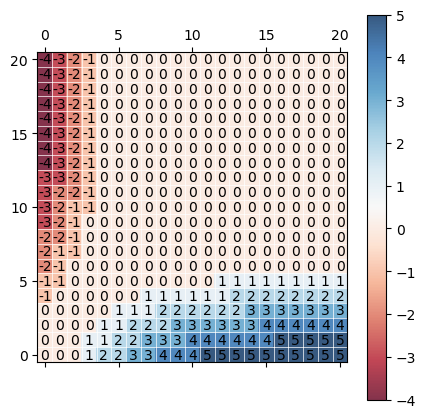

total reward:153769.19770069688	delta:2.554694866032321
total reward:154059.79995512165	delta:1.4607782929048767
total reward:154275.21501226703	delta:0.9581804832718603
total reward:154437.48712634112	delta:0.6225670613177385
total reward:154560.91895016094	delta:0.422741937824469
total reward:154655.29576830537	delta:0.29789684343006684
total reward:154727.66635768	delta:0.21705640278253213
total reward:154783.26070163734	delta:0.1606398455662088
total reward:154826.01818094304	delta:0.12010426694558873


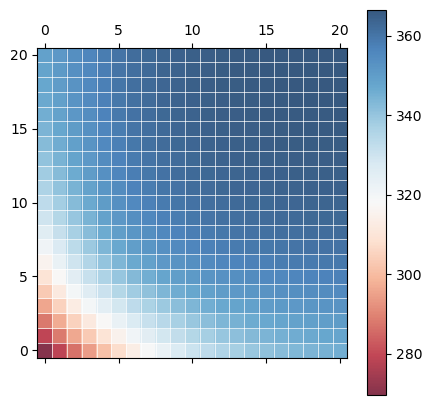

In [7]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.1)
plot_values(values)

- Third iterations 

policy iteration: 0 ..
policy iteration: 1 ..   
policy updated!7         


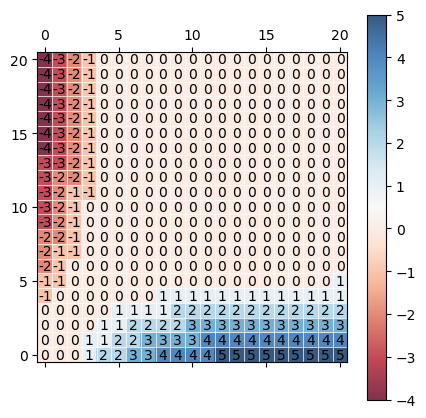

total reward:154890.0425809097	delta:0.2948170872965079
total reward:154913.15637468867	delta:0.1105517549653996
total reward:154930.55463994038	delta:0.07123473589354035
total reward:154943.78551789184	delta:0.04744353674487911
total reward:154953.90454584613	delta:0.03313401463174159
total reward:154961.6673812995	delta:0.024234296006397926
total reward:154967.63307155384	delta:0.017945205785053986
total reward:154972.22270740906	delta:0.0134100348665811
total reward:154975.75634679061	delta:0.010095580457516462


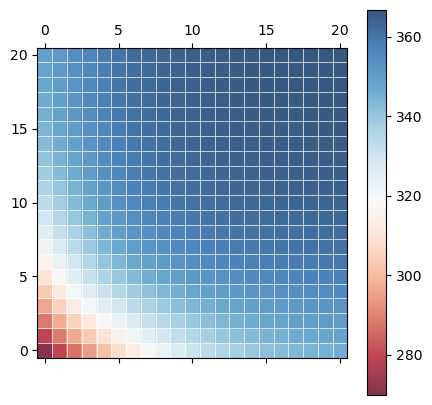

In [8]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.01)
plot_values(values)

- fourth iterations

policy iteration: 0 ..
policy updated!2         


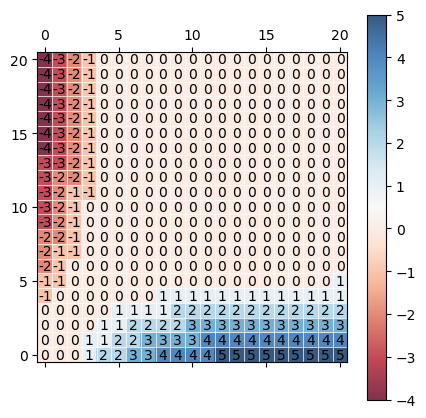

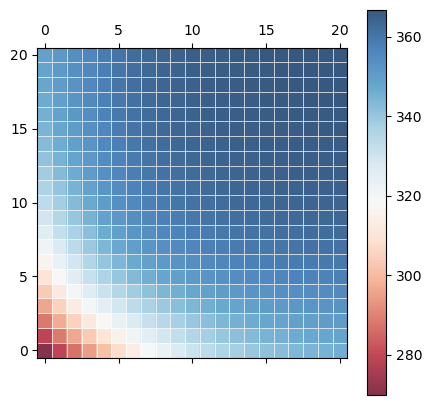

In [9]:
policy = policy_improvement(values, policy)
plot_policy(policy)
values = policy_evaluation(values, policy, theta=0.01)
plot_values(values)